<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Sebastian Raschka의 도서 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>를 위한 보조 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 4장: 텍스트 생성을 위한 GPT 모델 직접 구현

In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.6.0
tiktoken version: 0.9.0


- 이번 장에서는 GPT와 유사한 LLM 아키텍처를 구현하고, 다음 장에서는 이 LLM 학습에 집중합니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

## 4.1 LLM 아키텍처 코딩하기

- 1장에서는 GPT와 Llama 같은 모델이 원래 트랜스포머 구조의 디코더 부분을 기반으로 하여 단어를 순차적으로 생성한다고 설명했습니다
- 따라서 이러한 LLM을 흔히 "디코더 기반" LLM이라고 부릅니다
- 전통적인 딥러닝 모델과 달리 LLM이 거대한 이유는 코드 양이 아니라 방대한 파라미터 수 때문입니다
- LLM 아키텍처에서는 동일한 구성 요소가 여러 번 반복되는 모습을 자주 보게 될 것입니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- 앞 장들에서는 설명을 쉽게 하기 위해 입력과 출력 토큰의 임베딩 차원을 작게 설정해 도식이 한 페이지에 들어가도록 했습니다
- 이번 장에서는 소형 GPT-2 모델에 가까운 임베딩과 모델 크기를 다룹니다
- Radford 등의 [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) 논문에 제시된 가장 작은 GPT-2 모델(파라미터 1억 2,400만 개)의 아키텍처를 직접 구현합니다. (초기 보고에는 1억 1,700만 개라고 적혀 있었지만, 이후 모델 가중치 저장소에서 수정되었습니다.)
- 6장에서는 본 구현에 사전 학습된 가중치를 불러오는 방법을 다루며, 345M·762M·1542M 파라미터 모델 크기와도 호환될 예정입니다

- 1억 2,400만 개 파라미터를 가진 GPT-2 모델의 구성은 다음과 같습니다:

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 어휘 크기
    "context_length": 1024, # 컨텍스트 길이
    "emb_dim": 768,         # 임베딩 차원
    "n_heads": 12,          # 어텐션 헤드 수
    "n_layers": 12,         # 레이어 개수
    "drop_rate": 0.1,       # 드롭아웃 비율
    "qkv_bias": False       # 쿼리·키·밸류 바이어스 사용 여부
}

- 이후 코드가 길어지는 것을 막기 위해 변수 이름을 짧게 사용합니다
- `"vocab_size"`는 2장에서 다룬 BPE 토크나이저가 지원하는 50,257개 어휘 크기를 의미합니다
- `"context_length"`는 2장에서 소개한 위치 임베딩 덕분에 모델이 한 번에 처리할 수 있는 최대 입력 토큰 수를 뜻합니다
- `"emb_dim"`은 각 입력 토큰을 768차원 벡터로 변환하는 임베딩 크기입니다
- `"n_heads"`는 3장에서 구현한 멀티헤드 어텐션의 헤드 개수입니다
- `"n_layers"`는 모델 안에 있는 트랜스포머 블록 개수이며, 다음 절에서 구현합니다
- `"drop_rate"`는 3장에서 다룬 드롭아웃의 강도를 뜻하며, 0.1은 학습 중 은닉 유닛의 10%를 꺼 과적합을 줄인다는 의미입니다
- `"qkv_bias"`는 3장에서 구현한 멀티헤드 어텐션의 `Linear` 계층이 쿼리(Q)·키(K)·밸류(V) 텐서를 계산할 때 바이어스 벡터를 사용할지 여부를 결정합니다. 현대 LLM에서는 보통 비활성화하며, 5장에서 OpenAI의 GPT-2 사전 학습 가중치를 불러올 때 다시 살펴보겠습니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="500px">

In [3]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # TransformerBlock을 위한 자리표시자
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # LayerNorm을 위한 자리표시자
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 단순 자리표시자

    def forward(self, x):
        # 이 블록은 아무 작업도 하지 않고 입력을 그대로 반환합니다.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 여기의 파라미터는 LayerNorm 인터페이스를 흉내 내기 위한 것입니다.

    def forward(self, x):
        # 이 계층도 아무 작업 없이 입력을 그대로 반환합니다.
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="500px">

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


---

**노트**

- Windows나 Linux에서 이 코드를 실행하면 아래와 같은 값이 출력될 수 있습니다:

```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- 무작위 값일 뿐이므로 걱정하지 않아도 되며, 이어지는 내용을 그대로 진행하면 됩니다
- 이런 차이는 PyTorch 컴파일 방식에 따라 운영체제별로 `nn.Dropout`의 동작이 달라서 발생할 수 있으며, 자세한 내용은 [PyTorch 이슈 트래커](https://github.com/pytorch/pytorch/issues/121595)에서 확인할 수 있습니다

---

## 4.2 레이어 정규화를 이용한 활성값 정규화

- 레이어 정규화(레이어노름, [Ba et al. 2016](https://arxiv.org/abs/1607.06450))는 신경망 층의 활성값을 평균 0, 분산 1로 맞춥니다
- 이를 통해 학습이 안정되고 효과적인 가중치에 더 빠르게 수렴할 수 있습니다
- 레이어 정규화는 이후 구현할 트랜스포머 블록에서 멀티헤드 어텐션 모듈 앞뒤에 적용되며, 최종 출력층 앞에서도 사용됩니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">

- 작은 입력 예시를 간단한 신경망 층에 통과시켜 레이어 정규화가 어떻게 동작하는지 살펴보겠습니다

In [6]:
torch.manual_seed(123)

# 특성 5개를 가진 학습 예시 2개 생성
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 위의 두 입력 각각에 대해 평균과 분산을 계산해 봅시다

In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 정규화는 두 입력(각 행)에 독립적으로 적용됩니다. `dim=-1`을 사용하면 행 차원 대신 마지막 차원(여기서는 특성 차원)을 따라 계산합니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">

- 평균을 빼고 분산(표준편차의 제곱근)으로 나누면 열(특성) 차원에서 평균 0, 분산 1이 되도록 값을 가운데 맞출 수 있습니다

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 각 입력은 평균 0, 분산 1로 정규화됩니다. 가독성을 위해 PyTorch의 과학적 표기법을 끌 수 있습니다

In [9]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 위에서는 각 입력의 특성을 정규화했습니다
- 같은 아이디어로 `LayerNorm` 클래스를 직접 구현해 보겠습니다

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**스케일과 시프트**

- 평균을 빼고 분산으로 나누는 정규화 외에 `scale`과 `shift`라는 두 개의 학습 가능한 파라미터를 추가했습니다
- 초기값 `scale`=1, `shift`=0은 출력에 영향을 주지 않지만, 학습 과정에서 LLM이 필요하다고 판단하면 이 값을 조정해 성능을 높일 수 있습니다
- 즉, 모델이 데이터에 가장 알맞은 스케일링과 시프트를 학습할 수 있게 해 줍니다
- 또한 분산이 0일 때 0으로 나누는 오류를 피하려고 제곱근을 계산하기 전에 작은 값(`eps`)을 더합니다

**편향된 분산(biased variance)**
- 위 분산 계산에서 `unbiased=False`로 두면 표본 크기 n(여기서는 특성 수 또는 열 수)을 분모로 사용하는 $rac{\sum_i (x_i - ar{x})^2}{n}$ 공식을 사용하게 됩니다. 이는 분모에 `n-1`을 쓰는 벨셀 보정을 적용하지 않으므로 분산의 편향 추정치를 제공합니다 
- LLM처럼 임베딩 차원 `n`이 매우 큰 경우 `n`과 `n-1`의 차이는 사실상 무시할 수 있습니다
- GPT-2도 정규화 층에서 편향된 분산을 사용했기 때문에, 이후 장에서 불러올 사전 학습 가중치와 호환되도록 동일한 설정을 채택했습니다

- 이제 `LayerNorm`을 직접 활용해 보겠습니다:

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [12]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

## 4.3 GELU 활성화를 사용하는 피드포워드 네트워크 구현

- 이번 절에서는 LLM의 트랜스포머 블록에서 사용되는 작은 신경망 하위 모듈을 구현합니다
- 먼저 활성 함수부터 살펴보겠습니다
- 딥러닝에서는 구조가 단순하고 다양한 아키텍처에서 효과적인 ReLU(정류 선형 유닛) 활성 함수를 자주 사용합니다
- LLM에서는 전통적인 ReLU 외에도 여러 활성 함수를 사용하며, 대표적으로 GELU(Gaussian Error Linear Unit)와 SwiGLU(Swish-Gated Linear Unit)가 있습니다
- GELU와 SwiGLU는 각각 가우시안·시그모이드 게이팅을 결합한 매끄러운 활성 함수로, 구간별 선형 함수인 ReLU보다 깊은 모델에서 더 좋은 성능을 내는 경우가 많습니다

- GELU([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415))는 여러 방식으로 구현할 수 있으며, 정확한 정의는 GELU(x)=x⋅Φ(x)입니다. 여기서 Φ(x)는 표준 가우시안 분포의 누적분포함수(CDF)입니다.
- 실제 구현에서는 더 계산이 간단한 근사식을 사용하는 경우가 많습니다. 예를 들어 $	ext{GELU}(x) pprox 0.5 \cdot x \cdot \left(1 + 	anh\left[\sqrt{rac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3ight)ight]ight)$ 을 사용하며, 원래 GPT-2 모델도 이 근사식을 이용해 학습되었습니다

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

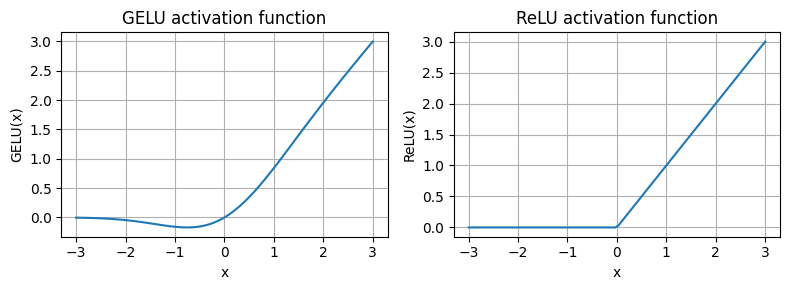

In [14]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# 예시 데이터
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- ReLU는 입력이 양수이면 그대로 출력하고, 음수이면 0을 출력하는 구간별 선형 함수입니다
- GELU는 음수 영역에서도 (약 -0.75 지점을 제외하고) 0이 아닌 기울기를 유지하는 매끄러운 비선형 함수로, ReLU를 부드럽게 근사합니다

- 이제 트랜스포머 블록에서 사용할 작은 신경망 모듈 `FeedForward`를 구현해 보겠습니다:

In [15]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)

# 입력 형태: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">

## 4.4 쇼트컷(스킵) 연결 추가하기

- 이제 쇼트컷 연결(스킵 또는 잔차 연결)의 개념을 살펴보겠습니다
- 원래는 컴퓨터 비전을 위한 깊은 신경망(ResNet)에서 기울기 소실 문제를 줄이기 위해 제안되었습니다
- 쇼트컷 연결은 기울기가 네트워크를 더 수월하게 통과할 수 있도록 짧은 경로를 제공합니다
- 이를 위해 한 층의 출력을 이후 층의 출력에 더하면서, 그 사이의 한두 층을 건너뜁니다
- 아래 작은 예제 네트워크로 이 아이디어를 그림으로 살펴보겠습니다:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

- 코드로 표현하면 다음과 같습니다:

In [18]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # 현재 층 출력 계산
            layer_output = layer(x)
            # 쇼트컷 적용 가능 여부 확인
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # 순전파 실행
    output = model(x)
    target = torch.tensor([[0.]])

    # 타깃과 출력의 차이를 기준으로 손실 계산
    # (타깃과 출력이 얼마나 가까운지)
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # 역전파로 기울기 계산
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # 가중치 기울기의 절댓값 평균 출력
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 먼저 쇼트컷 연결이 **없는** 경우의 기울기 값을 출력해 보겠습니다:

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- 다음으로 쇼트컷 연결이 **있는** 경우의 기울기 값을 확인해 보겠습니다:

In [20]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- 위 출력에서 보듯 쇼트컷 연결을 사용하면 초반 층(`layer.0`)에서 기울기가 사라지지 않습니다. 이 아이디어를 다음 절의 트랜스포머 블록 구현에 적용할 것입니다

## 4.5 트랜스포머 블록에서 어텐션과 선형층 연결하기

- 이제 앞에서 다룬 개념들을 모아 트랜스포머 블록을 구성하겠습니다
- 트랜스포머 블록은 이전 장에서 구현한 인과 멀티헤드 어텐션과, 이번 장에서 구현한 선형층·피드포워드 네트워크를 결합합니다
- 여기에 드롭아웃과 쇼트컷 연결도 함께 사용합니다

In [21]:
# 로컬에 `previous_chapters.py` 파일이 없으면
# `llms-from-scratch` PyPI 패키지에서 임포트할 수 있습니다.
# 자세한 내용: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 예시:
# 예: from llms_from_scratch.ch03 import MultiHeadAttention

from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 어텐션 블록용 쇼트컷 연결
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # 형태: [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # 원래 입력을 다시 더함

        # 피드포워드 블록용 쇼트컷 연결
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # 원래 입력을 다시 더함

        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- 예를 들어 토큰이 6개인 입력 샘플 2개가 있고, 각 토큰이 768차원 임베딩 벡터라고 합시다. 그러면 이 트랜스포머 블록은 셀프 어텐션과 선형층을 거쳐 유사한 크기의 출력을 만듭니다
- 출력은 이전 장에서 다룬 컨텍스트 벡터를 확장한 표현이라고 볼 수 있습니다

In [22]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # 형태: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 GPT 모델 코딩하기

- 이제 거의 다 왔습니다. 이 장 맨 앞에서 구현한 아키텍처에 트랜스포머 블록을 끼워 넣어 실제로 사용할 수 있는 GPT 구조를 완성해 봅시다
- 트랜스포머 블록은 여러 번 반복되는데, 가장 작은 124M GPT-2 모델에서는 12번 반복합니다:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- `cfg["n_layers"] = 12`일 때의 코드 구현은 다음과 같습니다:

In [23]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # 형태: [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 124M 파라미터 구성으로 GPT 모델을 초기 무작위 가중치와 함께 생성하면 다음과 같습니다:

In [24]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- 이 모델은 다음 장에서 학습시킬 예정입니다
- 다만 크기에 대해 다시 한번 짚고 넘어가겠습니다. 앞서 124M 파라미터 모델이라고 했는데, 실제로는 얼마나 되는지 확인해 봅시다:

In [25]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- 위 결과를 보면 모델 파라미터 수가 124M이 아니라 163M입니다. 왜 그럴까요?
- 원래 GPT-2 논문에서는 토큰 임베딩 층(`tok_emb`)을 출력층과 공유하는 가중치 결합(weight tying)을 적용했습니다. 즉 `self.out_head.weight = self.tok_emb.weight`로 설정합니다
- 토큰 임베딩 층은 50,257차원 원-핫 입력을 768차원 임베딩으로 투영합니다
- 출력층은 768차원 임베딩을 다시 50,257차원 표현으로 투영해 단어를 복원합니다(자세한 내용은 다음 절에서 다룹니다)
- 두 층의 가중치 행렬 형태가 같기 때문에 파라미터 수도 동일합니다
- 따라서 출력층의 파라미터를 빼 주면 124M 파라미터 모델과 일치하게 됩니다

In [26]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- GPT-2 논문에서는 토큰 임베딩 행렬을 그대로 출력 행렬로 재사용했습니다
- 따라서 출력층 파라미터 수를 빼면 124M 파라미터 모델 크기가 됩니다:

In [27]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- 실제 학습에서는 가중치를 묶지 않는 편이 더 다루기 쉬워서 여기서는 적용하지 않았습니다
- 하지만 5장에서 사전 학습된 가중치를 불러올 때는 이 weight tying 아이디어를 다시 적용할 예정입니다
- 마지막으로 모델의 메모리 요구량을 계산해 두면 참고하기 좋습니다:

In [28]:
# 총 바이트 수 계산(float32 기준, 파라미터당 4바이트 가정)
total_size_bytes = total_params * 4

# 메가바이트 단위로 변환
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- 연습: [GPT-2 논문](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C)에 나온 다른 구성도 시도해 보세요.

    - **GPT2-small** (이번에 구현한 124M 구성)
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16

    - **GPT2-large**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20

    - **GPT2-XL**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 텍스트 생성하기

- 앞에서 구현한 GPT 모델 같은 LLM은 한 번에 하나의 단어(토큰)를 생성합니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- 아래 `generate_text_simple` 함수는 그리디 디코딩(greedy decoding)을 구현한 것으로, 간단하고 빠르게 텍스트를 생성할 수 있습니다
- 그리디 디코딩에서는 매 단계마다 확률이 가장 높은 단어(또는 토큰)를 다음 출력으로 선택합니다. 가장 큰 로그확률(logit)이 가장 높은 확률에 대응하므로, 엄밀히는 softmax를 계산하지 않아도 됩니다
- 다음 장에서는 더 발전된 `generate_text` 함수를 구현할 예정입니다
- 아래 그림은 입력 컨텍스트가 주어졌을 때 GPT 모델이 다음 단어 토큰을 생성하는 과정을 보여 줍니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [29]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx는 현재 컨텍스트에서 (batch, n_tokens) 형태의 토큰 인덱스 배열
    for _ in range(max_new_tokens):
        
        # 컨텍스트 길이를 초과하면 지원되는 길이에 맞게 뒤쪽만 남깁니다
        # 예: LLM이 5개 토큰만 지원하고 현재 컨텍스트가 10개라면
        # 마지막 5개 토큰만 컨텍스트로 사용합니다
        idx_cond = idx[:, -context_size:]
        
        # 예측값 계산
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 마지막 타임스텝에만 집중
        # (batch, n_tokens, vocab_size)가 (batch, vocab_size)로 변환
        logits = logits[:, -1, :]  

        # softmax를 적용해 확률 계산
        probas = torch.softmax(logits, dim=-1)  # 형태: (batch, vocab_size)

        # 확률이 가장 높은 어휘 인덱스 선택
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # 형태: (batch, 1)

        # 선택한 인덱스를 시퀀스 끝에 추가
        idx = torch.cat((idx, idx_next), dim=1)  # 형태: (batch, n_tokens+1)

    return idx

- 위 `generate_text_simple` 함수는 한 번에 하나의 토큰을 생성하는 반복 과정을 구현합니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- 입력 예시를 준비해 보겠습니다:

In [30]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [31]:
model.eval() # 드롭아웃 비활성화

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- 배치 차원을 제거하고 텍스트로 다시 변환합니다:

In [32]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- 아직 학습되지 않은 모델이므로 위와 같이 무작위에 가까운 문장이 출력됩니다
- 이 모델은 다음 장에서 학습시킬 예정입니다

## 요약 및 핵심 포인트

- [./gpt.py](./gpt.py) 스크립트에는 이 노트북에서 구현한 GPT 모델이 독립적으로 정리되어 있습니다
- 연습 문제 해설은 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에서 확인할 수 있습니다